# FW20 Trading System

## FW20 Futures

FW20 futures are standardized financial contracts traded on [the Warsaw Stock Exchange (GPW)](https://www.gpw.pl/en-home), where the underlying asset is the WIG20 index — a benchmark index representing the 20 largest companies on the Polish stock market.

### What Are FW20 Futures?

- FW20 stands for Futures on WIG20.
- These are cash-settled index futures, meaning there's no physical delivery of stocks—just a monetary settlement based on the index value.
- They allow investors to speculate, hedge, or gain leveraged exposure to the Polish equity market.

### Contract Specifications

- **Underlying asset**: WIG20 index
- **Multiplier**: 20 PLN per index point → If the contract is priced at 2,000 points, its nominal value is 40,000 PLN.
- **Settlement**: Cash only, no delivery of shares
- **Expiration months**: March, June, September, December (quarterly cycle)
- **Last trading day**: Third Friday of the expiration month (or the prior session if Friday is a holiday)

### Contract Symbol: FW20EYY20

- **F**: Futures contract
- **W20**: Underlying assest - WIG20 index
- **E**: Expiration month - H (March), M (June), U (September), Z (December)
- **YY**: Year of expiration
- **20**: Multiplier
- **Example**: FW20H2620 indicates futures contract expiring in June 2026

### How They’re Used

- **Speculation**: Traders bet on the direction of the WIG20 index.
- **Hedging**: Investors protect their portfolios against market downturns.
- **Arbitrage**: Exploit price differences between futures and spot markets.
- **Leverage**: Control a large position with relatively small capital.

### Risks

- Futures are highly leveraged, so small index movements can lead to large gains or losses.
- They require margin deposits and are marked-to-market daily.
- Not suitable for beginners without proper risk management.

### More Info

- [GPW's derivative page](https://www.gpw.pl/derivatives)
- [BOSSA's futures education section](https://bossa.pl/edukacja/kontrakty-opcje/kontrakty-terminowe/charakterystyka/kontrakty-na-indeksy) [PL version only]



## EDA

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
filepath = "data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

In [242]:
df.tail()

,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,
2025-09-25,2853,2856,2815,2825,20231,62808.0
2025-09-26,2828,2863,2813,2863,17378,65270.0
2025-09-29,2873,2880,2845,2859,13546,65238.0
2025-09-30,2854,2857,2830,2857,14266,66112.0
2025-10-01,2844,2885,2831,2878,18432,67739.0


In [243]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    2
dtype: int64

In [244]:
df['Open Interest'] = df['Open Interest'].ffill()
df['Open Interest'] = df['Open Interest'].astype(int)

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6932 entries, 1998-01-20 to 2025-10-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           6932 non-null   int64
 1   High           6932 non-null   int64
 2   Low            6932 non-null   int64
 3   Close          6932 non-null   int64
 4   Volume         6932 non-null   int64
 5   Open Interest  6932 non-null   int64
dtypes: int64(6)
memory usage: 379.1 KB


## Trading System

In [246]:
# calculate ATR
short_window = 2
long_window = 14

df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_short'] = df['TR'].rolling(window=short_window).mean()
df['ATR_long'] = df['TR'].rolling(window=long_window).mean()

In [247]:
# generate signals
signal_adj = 0.5

df['Signal'] = (df['ATR_short'] * signal_adj).bfill().astype(int)
df['Buy_Level'] = (df['Open'] + df['Signal'].shift(1)).astype(float)
df['Sell_Level'] = (df['Open'] - df['Signal'].shift(1)).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Buy_Level']) & df['Buy_Level'].notna()
df['Short_Entry'] = (df['Low'] < df['Sell_Level']) & df['Sell_Level'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
position = []
entry_price = []
current_pos = 0  # 1 = long, -1 = short, 0 = flat
last_entry = np.nan

for i in range(len(df)):
    long_signal = df['Long_Entry'].iloc[i]
    short_signal = df['Short_Entry'].iloc[i]

    if current_pos == 0:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]
        elif short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == 1:
        if short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == -1:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]

    position.append(current_pos)
    entry_price.append(last_entry)

df['Position'] = position
df['Entry_Price'] = entry_price

In [248]:
# --- Calculate PnL ---
# Create columns to store results
df['Daily_PnL'] = np.nan  # Actual PnL on the entry day (close - entry)

# Loop through rows
for i in range(1, len(df)):
    prev_pos = df['Position'].iloc[i - 1]
    curr_pos = df['Position'].iloc[i]
    curr_close = df['Close'].iloc[i]
    prev_close = df['Close'].iloc[i - 1]
    entry_price = df['Entry_Price'].iloc[i]

     # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and curr_pos != 0:
        df.at[df.index[i], 'Daily_PnL'] = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)

    # Case 2: New position opened from flat
    elif prev_pos == 0 and curr_pos != 0:
        df.at[df.index[i], 'Daily_PnL'] = (curr_close - entry_price) * curr_pos

    # Case 3: Holding position
    elif curr_pos == prev_pos and curr_pos != 0 and prev_pos != 0:
        df.at[df.index[i], 'Daily_PnL'] = (curr_close - prev_close) * curr_pos

# Calculate cumulative PnL
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum()


In [249]:
df.tail(20)

,Open,High,Low,Close,Volume,Open Interest,Prev_Close,H-L,H-PC,L-PC,...,ATR_long,Signal,Buy_Level,Sell_Level,Long_Entry,Short_Entry,Position,Entry_Price,Daily_PnL,Cumulative_PnL
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-04,2797,2842,2764,2833,24875,57367,2790,78,52,26,...,65.500000,29,2822.0,2772.0,True,True,1,2822.0,-21.0,18629.0
2025-09-05,2849,2865,2808,2810,23959,57246,2833,57,32,25,...,66.214286,33,2878.0,2820.0,False,True,-1,2820.0,-3.0,18626.0
2025-09-08,2822,2871,2814,2870,21896,61004,2810,57,61,4,...,66.142857,29,2855.0,2789.0,True,False,1,2855.0,-30.0,18596.0
2025-09-09,2862,2875,2829,2841,17960,60051,2870,46,5,41,...,65.642857,26,2891.0,2833.0,False,True,-1,2833.0,-45.0,18551.0
2025-09-10,2828,2834,2765,2815,32271,62040,2841,69,7,76,...,67.285714,30,2854.0,2802.0,False,True,-1,2833.0,26.0,18577.0
2025-09-11,2820,2871,2813,2860,24888,66275,2815,58,56,2,...,60.642857,33,2850.0,2790.0,True,False,1,2850.0,-25.0,18552.0
2025-09-12,2864,2874,2836,2838,23822,65553,2860,38,14,24,...,60.714286,24,2897.0,2831.0,False,False,1,2850.0,-22.0,18530.0
2025-09-15,2848,2871,2844,2865,61591,68557,2838,27,33,6,...,58.642857,17,2872.0,2824.0,False,False,1,2850.0,27.0,18557.0
2025-09-16,2874,2881,2817,2825,66208,69347,2865,64,16,48,...,57.642857,24,2891.0,2857.0,False,True,-1,2857.0,24.0,18581.0


In [250]:
# --- Calculate Drawdown ---
df['Cumulative_Max'] = df['Cumulative_PnL'].cummax()
df['Drawdown'] = df['Cumulative_PnL'] - df['Cumulative_Max']
df['Drawdown_Pct'] = df['Drawdown'] / df['Cumulative_Max'].replace(0, np.nan)
max_drawdown = df['Drawdown'].min()
max_drawdown_pct = df['Drawdown_Pct'].min()
print(f"Max Drawdown: {max_drawdown}, Max Drawdown %: {max_drawdown_pct}")

Max Drawdown: -900.0, Max Drawdown %: -1.7222222222222223


In [254]:
df.tail(20)

,Open,High,Low,Close,Volume,Open Interest,Prev_Close,H-L,H-PC,L-PC,...,Sell_Level,Long_Entry,Short_Entry,Position,Entry_Price,Daily_PnL,Cumulative_PnL,Cumulative_Max,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-04,2797,2842,2764,2833,24875,57367,2790,78,52,26,...,2772.0,True,True,1,2822.0,-21.0,18629.0,18921.0,-292.0,-0.015433
2025-09-05,2849,2865,2808,2810,23959,57246,2833,57,32,25,...,2820.0,False,True,-1,2820.0,-3.0,18626.0,18921.0,-295.0,-0.015591
2025-09-08,2822,2871,2814,2870,21896,61004,2810,57,61,4,...,2789.0,True,False,1,2855.0,-30.0,18596.0,18921.0,-325.0,-0.017177
2025-09-09,2862,2875,2829,2841,17960,60051,2870,46,5,41,...,2833.0,False,True,-1,2833.0,-45.0,18551.0,18921.0,-370.0,-0.019555
2025-09-10,2828,2834,2765,2815,32271,62040,2841,69,7,76,...,2802.0,False,True,-1,2833.0,26.0,18577.0,18921.0,-344.0,-0.018181
2025-09-11,2820,2871,2813,2860,24888,66275,2815,58,56,2,...,2790.0,True,False,1,2850.0,-25.0,18552.0,18921.0,-369.0,-0.019502
2025-09-12,2864,2874,2836,2838,23822,65553,2860,38,14,24,...,2831.0,False,False,1,2850.0,-22.0,18530.0,18921.0,-391.0,-0.020665
2025-09-15,2848,2871,2844,2865,61591,68557,2838,27,33,6,...,2824.0,False,False,1,2850.0,27.0,18557.0,18921.0,-364.0,-0.019238
2025-09-16,2874,2881,2817,2825,66208,69347,2865,64,16,48,...,2857.0,False,True,-1,2857.0,24.0,18581.0,18921.0,-340.0,-0.017969


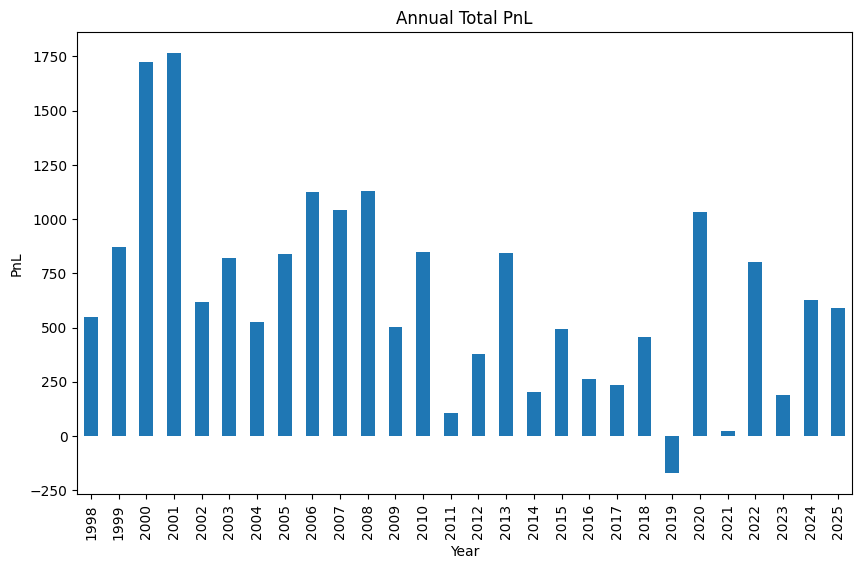

In [252]:
df['Daily_PnL'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Total PnL', figsize=(10, 6))
plt.ylabel('PnL')
plt.xlabel('Year')
plt.show()

Text(0, 0.5, 'Cumulative PnL')

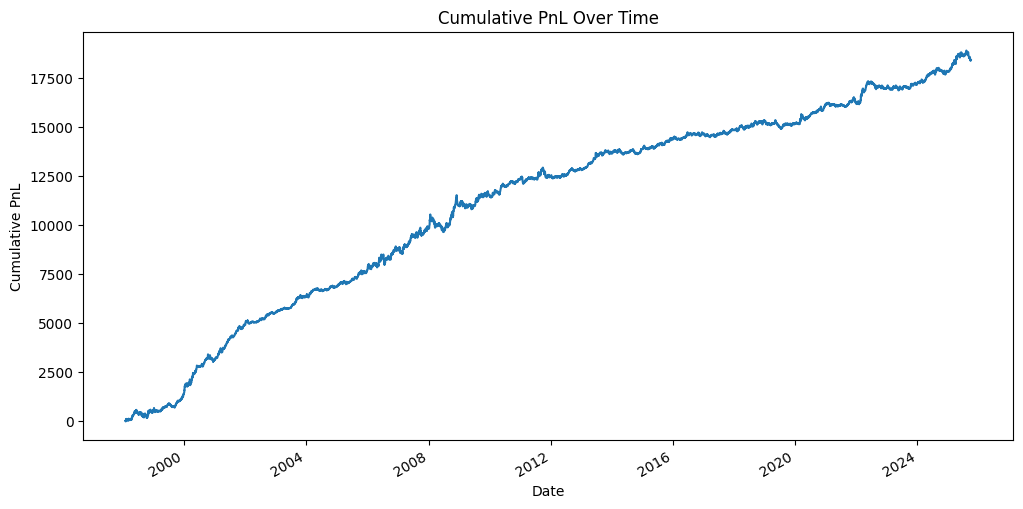

In [253]:
df['Cumulative_PnL'].plot(title='Cumulative PnL Over Time', figsize=(12, 6))
plt.ylabel('Cumulative PnL')